In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input

In [50]:
raw_data = pd.read_csv('/content/drive/MyDrive/번천/dataset/train_data.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/번천/dataset/test_data.csv')

In [51]:
raw_data.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0


In [52]:
raw_data['type'].value_counts()

0    432
1    369
2    366
3    306
4    306
5    249
6    249
7    186
Name: type, dtype: int64

In [53]:
raw_test['type'].value_counts()

0    1296
1    1107
2    1098
3     918
4     918
5     747
6     747
7     558
Name: type, dtype: int64

In [54]:
train_data = raw_data[['air_inflow', 'motor_current','motor_rpm', 'motor_temp', 'motor_vibe', 'out_pressure', 'air_end_temp', 'type']].copy()
test_data = raw_test[['air_inflow', 'motor_current','motor_rpm', 'motor_temp', 'motor_vibe', 'out_pressure', 'air_end_temp', 'type']].copy()

설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)

설비 번호 1: 20HP

설비 번호 2: 10HP

설비 번호 3: 50HP

In [55]:
hp30 = [0, 4, 5, 6, 7]
hp20 = [1]
hp10 = [2]
hp50 = [3]

In [56]:
# 설비별 데이터 세트 분리

train_data_30hp = train_data[train_data['type'].isin(hp30)].copy()
train_data_20hp = train_data[train_data['type'].isin(hp20)].copy()
train_data_10hp = train_data[train_data['type'].isin(hp10)].copy()
train_data_50hp = train_data[train_data['type'].isin(hp50)].copy()

In [57]:
# 설비별 데이터 세트 분리

test_data_30hp = test_data[test_data['type'].isin(hp30)].copy()
test_data_20hp = test_data[test_data['type'].isin(hp20)].copy()
test_data_10hp = test_data[test_data['type'].isin(hp10)].copy()
test_data_50hp = test_data[test_data['type'].isin(hp50)].copy()

# 모델 생성

In [31]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [49]:
timesteps = 3
n_features = 7
layer_1 = 32
layer_2 = 16

In [73]:
class lstm_ae(tf.keras.Model):
  def __init__(self, timesteps, n_features, layer_1, layer_2):
    super(lstm_ae).__init__()
    self.n_features = n_features
    self.timesteps = timesteps
    self.layer_1 = layer_1
    self.layer_2 = layer_2


  def encoder(self, x):
    x = layers.LSTM(self.layer_1, activation = 'relu', return_sequences = True)(x)
    x = layers.LSTM(self.layer_2, activation = 'relu', return_sequences = False)(x)
    en_output = layers.RepeatVector(self.timesteps)(x)
    return en_output

  def decoder(self, x):
    x = layers.LSTM(self.layer_2, activation = 'relu', return_sequences = True)(x)
    x = layers.LSTM(self.layer_1, activation = 'relu', return_sequences = True)(x)
    de_output = layers.TimeDistributed(layers.Dense(self.n_features))(x)

    return de_output

  def build(self):
    inputs = Input(shape = (self.timesteps, self.n_features))
    encoder = self.encoder(inputs)
    decoder = self.decoder(encoder)

    return Model(inputs, decoder)

# hp30

In [ ]:
def parallel(for_view, num):
  parallel_coordinates(frame = for_view[for_view['type'].isin(num)], class_column = 'type', colormap = plt.get_cmap('Set1'));

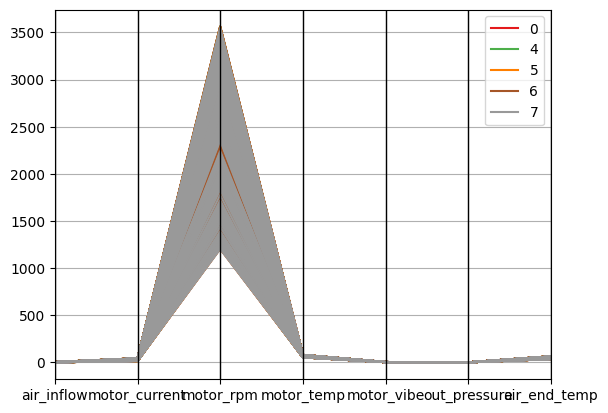

In [ ]:
parallel(train_data, hp30)

In [58]:
scaler_30hp = StandardScaler()

# 설비 라벨 제외
train_scale_30hp = scaler_30hp.fit_transform(train_data_30hp.drop(['type'], axis=1))
test_scale_30hp = scaler_30hp.transform(test_data_30hp.drop(['type'], axis=1))

In [63]:
# lstm 구조에 맞게 데이터 변형

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [67]:
train_slice_30hp = slicing(train_scale_30hp,3)
X_train, X_test = train_test_split(train_slice_30hp, test_size=0.2, random_state=123)

In [77]:
lstm_ae_30hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_30hp.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 3, 7)]            0         
                                                                 
 lstm_74 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_75 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_20 (RepeatVec  (None, 3, 16)            0         
 tor)                                                            
                                                                 
 lstm_76 (LSTM)              (None, 3, 16)             2112      
                                                                 
 lstm_77 (LSTM)              (None, 3, 32)             6272      
                                                          

In [78]:
lstm_ae_30hp.compile(optimizer = 'adam', loss = 'mse')

In [79]:
history = lstm_ae_30hp.fit(X_train, X_train,
                     epochs=150, batch_size=32,
                     validation_data=(X_test, X_test))

Epoch 1/150
36/36 [==============================] - 6s 24ms/step - loss: 0.8492 - val_loss: 0.8659
Epoch 2/150
36/36 [==============================] - 0s 9ms/step - loss: 0.7670 - val_loss: 0.6917
Epoch 3/150
36/36 [==============================] - 0s 9ms/step - loss: 0.6216 - val_loss: 0.6050
Epoch 4/150
36/36 [==============================] - 0s 10ms/step - loss: 0.5550 - val_loss: 0.5454
Epoch 5/150
36/36 [==============================] - 0s 9ms/step - loss: 0.4848 - val_loss: 0.4448
Epoch 6/150
36/36 [==============================] - 0s 9ms/step - loss: 0.3885 - val_loss: 0.3288
Epoch 7/150
36/36 [==============================] - 0s 9ms/step - loss: 0.3021 - val_loss: 0.2673
Epoch 8/150
36/36 [==============================] - 0s 9ms/step - loss: 0.2588 - val_loss: 0.2281
Epoch 9/150
36/36 [==============================] - 0s 8ms/step - loss: 0.2291 - val_loss: 0.1904
Epoch 10/150
36/36 [==============================] - 0s 10ms/step - loss: 0.1717 - val_loss: 0.1530
Epoch 

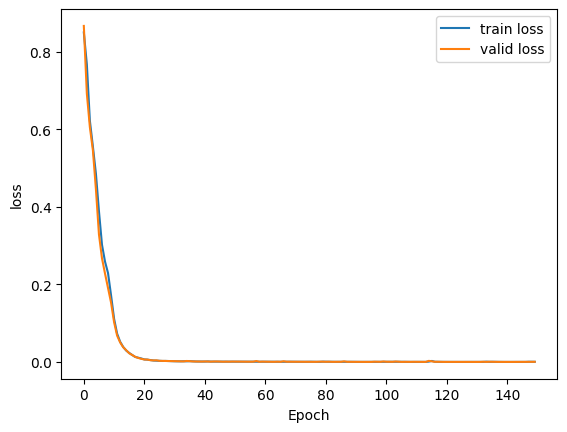

In [80]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [82]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [83]:
pred_train_30hp = lstm_ae_30hp.predict(train_slice_30hp)

45/45 [==============================] - 1s 2ms/step


In [84]:
train_mse_30hp = np.mean(np.square(flatten(train_slice_30hp) - flatten(pred_train_30hp)), axis =1 )
threshold_30hp = np.max(train_mse_30hp)
print(threshold_30hp)

0.004076005343357966


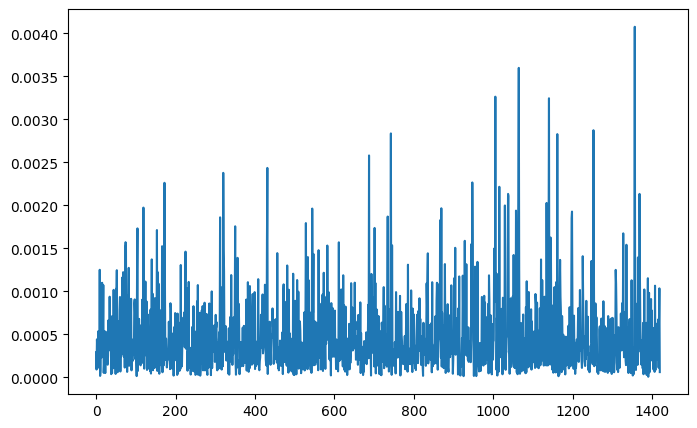

In [85]:
plt.figure(figsize = (8,5))
plt.plot(train_mse_30hp)

In [86]:
test_slice_30hp = slicing(test_scale_30hp,3)

In [87]:
pred_test_30hp = lstm_ae_30hp.predict(test_slice_30hp)

134/134 [==============================] - 0s 2ms/step


In [88]:
test_mse_30hp = np.mean(np.square(flatten(test_slice_30hp) - flatten(pred_test_30hp)), axis =1 )

(0.0, 0.005)

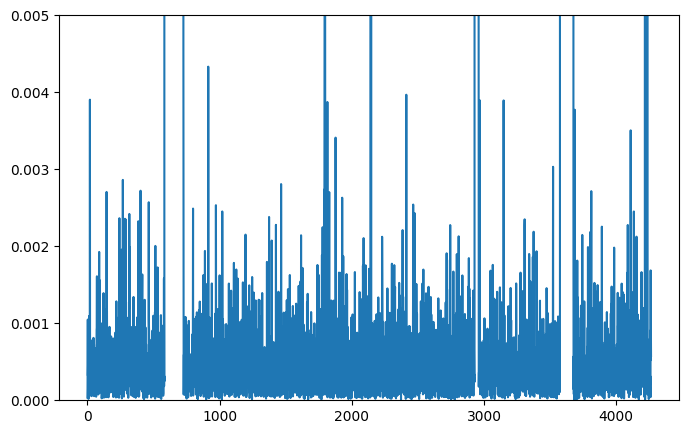

In [89]:
plt.figure(figsize = (8,5))
plt.plot(test_mse_30hp)
plt.ylim(0, 0.005)

In [90]:
anom_30hp = test_mse_30hp > threshold_30hp
np.sum(anom_30hp)

292

In [91]:
test_data_30hp

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
0,2.51,32.54,2662.0,69.58,3.48,0.7,53.28,0
1,2.66,34.45,2819.0,71.32,3.57,0.7,55.24,0
2,1.72,22.23,1819.0,60.21,3.01,0.7,42.74,0
3,2.20,28.50,2332.0,65.91,3.30,0.7,49.15,0
4,2.06,26.67,2182.0,64.24,3.21,0.7,47.28,0
...,...,...,...,...,...,...,...,...
7384,2.12,27.45,2246.0,64.96,3.25,0.7,48.08,7
7385,1.48,19.19,1570.0,57.44,2.87,0.7,39.63,7
7386,1.56,20.15,1649.0,58.32,2.92,0.7,40.61,7
7387,1.59,20.52,1679.0,58.66,2.93,0.7,40.99,7


In [95]:
def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)

In [96]:
test_data_30hp['y'] = plus(anom_30hp)

In [97]:
test_data_30hp['y']

0       0
1       0
2       0
3       0
4       0
       ..
7384    0
7385    0
7386    0
7387    0
7388    0
Name: y, Length: 4266, dtype: int64

# hp20

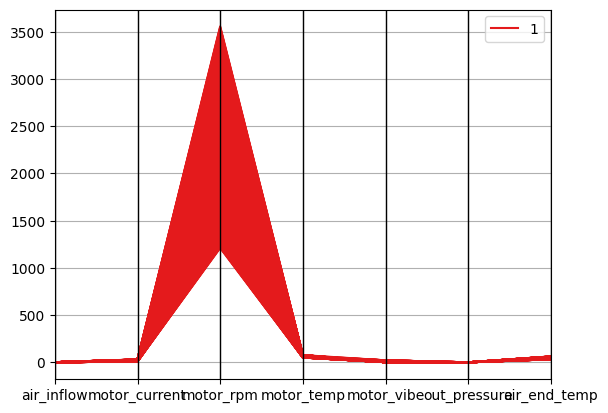

In [ ]:
parallel(train_data, hp20)

In [ ]:
parallel(train_data, hp20)

In [98]:
scaler_20hp = StandardScaler()

# 설비 라벨 제외
train_scale_20hp = scaler_20hp.fit_transform(train_data_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))

In [99]:
# lstm 구조에 맞게 데이터 변형

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [100]:
train_slice_20hp = slicing(train_scale_20hp,3)
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.2, random_state=123)

In [101]:
lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()
lstm_ae_20hp.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 3, 7)]            0         
                                                                 
 lstm_78 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_79 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_21 (RepeatVec  (None, 3, 16)            0         
 tor)                                                            
                                                                 
 lstm_80 (LSTM)              (None, 3, 16)             2112      
                                                                 
 lstm_81 (LSTM)              (None, 3, 32)             6272      
                                                          

In [102]:
lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

In [103]:
history = lstm_ae_20hp.fit(X_train, X_train,
                     epochs=150, batch_size=32,
                     validation_data=(X_test, X_test))

Epoch 1/150
10/10 [==============================] - 6s 71ms/step - loss: 0.8155 - val_loss: 1.0244
Epoch 2/150
10/10 [==============================] - 0s 10ms/step - loss: 0.8147 - val_loss: 1.0235
Epoch 3/150
10/10 [==============================] - 0s 13ms/step - loss: 0.8137 - val_loss: 1.0216
Epoch 4/150
10/10 [==============================] - 0s 11ms/step - loss: 0.8108 - val_loss: 1.0158
Epoch 5/150
10/10 [==============================] - 0s 12ms/step - loss: 0.8015 - val_loss: 0.9914
Epoch 6/150
10/10 [==============================] - 0s 10ms/step - loss: 0.7616 - val_loss: 0.9893
Epoch 7/150
10/10 [==============================] - 0s 10ms/step - loss: 0.7270 - val_loss: 0.8988
Epoch 8/150
10/10 [==============================] - 0s 10ms/step - loss: 0.6877 - val_loss: 0.8594
Epoch 9/150
10/10 [==============================] - 0s 12ms/step - loss: 0.6532 - val_loss: 0.8389
Epoch 10/150
10/10 [==============================] - 0s 10ms/step - loss: 0.6307 - val_loss: 0.8198

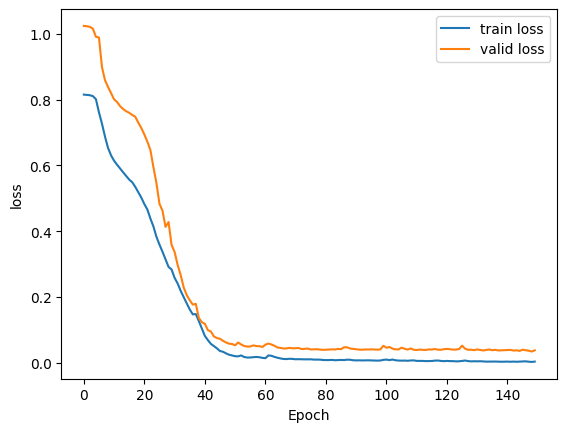

In [104]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [105]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [106]:
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)

12/12 [==============================] - 0s 3ms/step


In [113]:
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.mean(train_mse_20hp)+ 5*np.std(train_mse_20hp)
print(threshold_20hp)

0.8320685898050217


(0.0, 0.05)

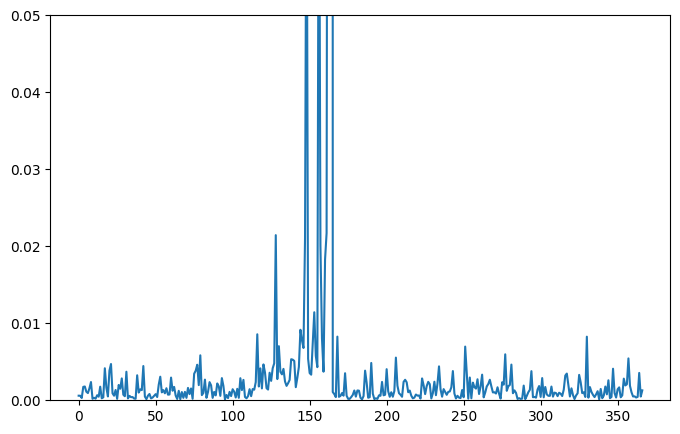

In [116]:
plt.figure(figsize = (8,5))
plt.plot(train_mse_20hp)
plt.ylim(0, 0.05)

이상한 데이터 제외하고 다시 학습

In [186]:
boolean = (train_mse_20hp < np.mean(train_mse_20hp))*1
first = np.where(boolean == 0)[0][0] - 2
last = np.where(boolean == 0)[0][-1]

print(first)
print(last)

126
164


In [200]:
new_train_20hp = pd.concat([train_data_20hp.iloc[:first], train_data_20hp.iloc[last + 1:]])

In [204]:
new_train_20hp

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
432,1.73,25.60,2973.0,71.03,3.45,0.7,55.16,1
433,1.31,19.32,2244.0,62.93,3.05,0.7,46.05,1
434,1.33,19.69,2287.0,63.41,3.07,0.7,46.59,1
435,1.87,27.56,3200.0,73.56,3.58,0.7,58.00,1
436,1.68,24.78,2878.0,69.98,3.40,0.7,53.98,1
...,...,...,...,...,...,...,...,...
796,0.72,10.56,1226.0,51.62,2.48,0.7,33.33,1
797,0.86,12.68,1473.0,54.37,2.62,0.7,36.41,1
798,0.83,12.31,1430.0,53.89,2.59,0.7,35.88,1
799,1.77,26.07,3028.0,71.64,3.48,0.7,55.85,1


In [206]:
new_scaler_20hp = StandardScaler()

# 설비 라벨 제외
new_train_scale_20hp = new_scaler_20hp.fit_transform(new_train_20hp.drop(['type'], axis=1))
new_test_scale_20hp = new_scaler_20hp.transform(test_data_20hp.drop(['type', 'y'], axis=1))

In [207]:
# lstm 구조에 맞게 데이터 변형

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [208]:
train_slice_20hp = slicing(new_train_scale_20hp,3)
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.2, random_state=123)

In [209]:
new_lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()
new_lstm_ae_20hp.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 3, 7)]            0         
                                                                 
 lstm_90 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_91 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_24 (RepeatVec  (None, 3, 16)            0         
 tor)                                                            
                                                                 
 lstm_92 (LSTM)              (None, 3, 16)             2112      
                                                                 
 lstm_93 (LSTM)              (None, 3, 32)             6272      
                                                          

In [210]:
new_lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

In [211]:
history = new_lstm_ae_20hp.fit(X_train, X_train,
                     epochs=150, batch_size=32,
                     validation_data=(X_test, X_test))

Epoch 1/150
9/9 [==============================] - 8s 173ms/step - loss: 0.8522 - val_loss: 0.8752
Epoch 2/150
9/9 [==============================] - 0s 28ms/step - loss: 0.8518 - val_loss: 0.8748
Epoch 3/150
9/9 [==============================] - 0s 27ms/step - loss: 0.8513 - val_loss: 0.8738
Epoch 4/150
9/9 [==============================] - 0s 27ms/step - loss: 0.8501 - val_loss: 0.8714
Epoch 5/150
9/9 [==============================] - 0s 27ms/step - loss: 0.8468 - val_loss: 0.8653
Epoch 6/150
9/9 [==============================] - 0s 21ms/step - loss: 0.8365 - val_loss: 0.8429
Epoch 7/150
9/9 [==============================] - 0s 22ms/step - loss: 0.8155 - val_loss: 0.7964
Epoch 8/150
9/9 [==============================] - 0s 20ms/step - loss: 0.7924 - val_loss: 0.8081
Epoch 9/150
9/9 [==============================] - 0s 24ms/step - loss: 0.7787 - val_loss: 0.7790
Epoch 10/150
9/9 [==============================] - 0s 20ms/step - loss: 0.7412 - val_loss: 0.7264
Epoch 11/150
9/9 [

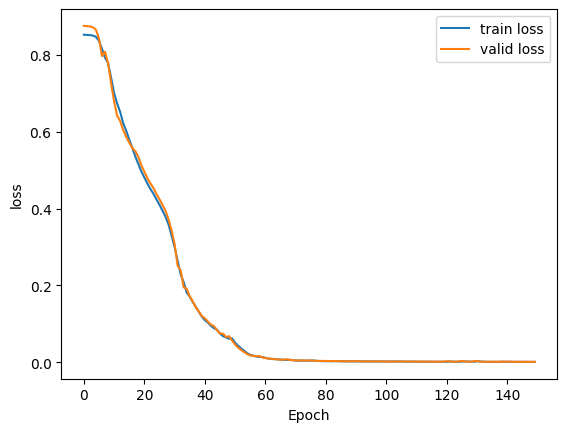

In [212]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [213]:
pred_train_20hp = new_lstm_ae_20hp.predict(train_slice_20hp)

11/11 [==============================] - 1s 3ms/step


In [216]:
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp) #np.mean(train_mse_20hp)+ 5*np.std(train_mse_20hp)
print(threshold_20hp)

0.01038615902937867


(0.0, 0.05)

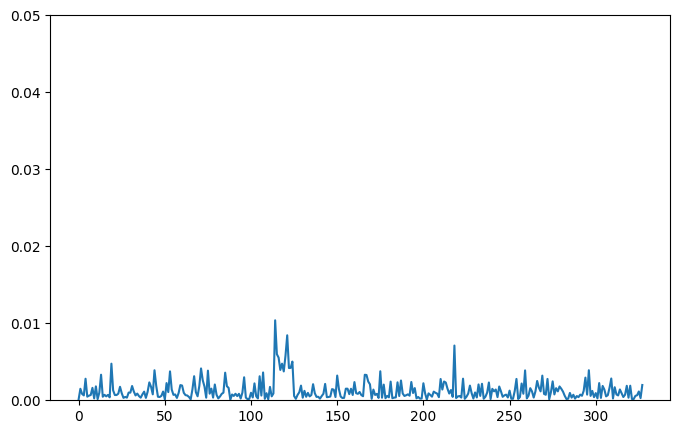

In [215]:
plt.figure(figsize = (8,5))
plt.plot(train_mse_20hp)
plt.ylim(0, 0.05)

In [222]:
test_slice_20hp = slicing(new_test_scale_20hp,3)

In [223]:
pred_test_20hp = new_lstm_ae_20hp.predict(test_slice_20hp)

35/35 [==============================] - 0s 6ms/step


In [224]:
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )

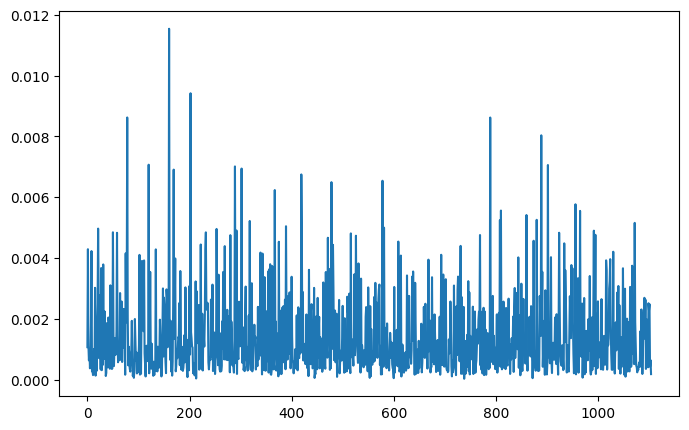

In [225]:
plt.figure(figsize = (8,5))
plt.plot(test_mse_20hp)

In [226]:
anom_20hp = test_mse_20hp > threshold_20hp
np.sum(anom_20hp)

1

In [227]:
test_data_20hp

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type,y
1296,1.95,28.81,3346.0,75.18,3.66,0.7,59.83,1,0
1297,0.74,10.91,1267.0,52.08,2.50,0.7,33.84,1,0
1298,0.97,14.31,1662.0,56.47,2.72,0.7,38.78,1,0
1299,2.05,30.31,3520.0,77.11,3.76,0.7,62.00,1,0
1300,1.60,23.62,2743.0,68.48,3.32,0.7,52.29,1,0
...,...,...,...,...,...,...,...,...,...
2398,1.01,14.85,1725.0,57.17,2.76,0.7,39.56,1,0
2399,1.05,15.46,1795.0,57.94,2.80,0.7,40.44,1,0
2400,1.67,24.70,2868.0,69.87,3.39,0.7,53.85,1,0
2401,0.84,12.39,1439.0,53.99,2.60,0.7,35.99,1,0


In [228]:
def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)


In [229]:
test_data_20hp['y'] = plus(anom_20hp)

In [230]:
test_data_20hp['y']

1296    0
1297    0
1298    0
1299    0
1300    0
       ..
2398    0
2399    0
2400    0
2401    0
2402    0
Name: y, Length: 1107, dtype: int64

맞지 않은 데이터 제거 필요

# hp10


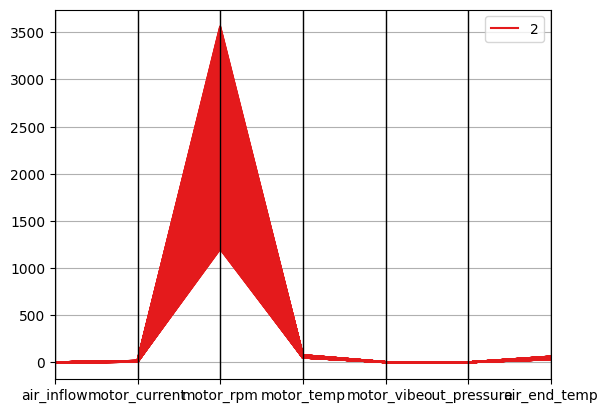

In [ ]:
parallel(train_data, hp10)

In [122]:
scaler_10hp = StandardScaler()

# 설비 라벨 제외
train_scale_10hp = scaler_10hp.fit_transform(train_data_10hp.drop(['type'], axis=1))
test_scale_10hp = scaler_10hp.transform(test_data_10hp.drop(['type'], axis=1))

In [123]:
train_scale_10hp.shape

(366, 7)

In [124]:
# lstm 구조에 맞게 데이터 변형

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [125]:
train_slice_10hp = slicing(train_scale_10hp,3)
X_train, X_test = train_test_split(train_slice_10hp, test_size=0.2, random_state=123)

In [126]:
lstm_ae_10hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_10hp.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 3, 7)]            0         
                                                                 
 lstm_82 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_83 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_22 (RepeatVec  (None, 3, 16)            0         
 tor)                                                            
                                                                 
 lstm_84 (LSTM)              (None, 3, 16)             2112      
                                                                 
 lstm_85 (LSTM)              (None, 3, 32)             6272      
                                                          

In [127]:
lstm_ae_10hp.compile(optimizer = 'adam', loss = 'mse')

In [128]:
history = lstm_ae_10hp.fit(X_train, X_train,
                     epochs=150, batch_size=32,
                     validation_data=(X_test, X_test))

Epoch 1/150
10/10 [==============================] - 5s 70ms/step - loss: 0.8598 - val_loss: 0.8473
Epoch 2/150
10/10 [==============================] - 0s 10ms/step - loss: 0.8587 - val_loss: 0.8461
Epoch 3/150
10/10 [==============================] - 0s 10ms/step - loss: 0.8567 - val_loss: 0.8431
Epoch 4/150
10/10 [==============================] - 0s 12ms/step - loss: 0.8514 - val_loss: 0.8334
Epoch 5/150
10/10 [==============================] - 0s 11ms/step - loss: 0.8319 - val_loss: 0.7964
Epoch 6/150
10/10 [==============================] - 0s 12ms/step - loss: 0.7777 - val_loss: 0.7148
Epoch 7/150
10/10 [==============================] - 0s 13ms/step - loss: 0.7192 - val_loss: 0.6847
Epoch 8/150
10/10 [==============================] - 0s 11ms/step - loss: 0.6853 - val_loss: 0.6464
Epoch 9/150
10/10 [==============================] - 0s 11ms/step - loss: 0.6572 - val_loss: 0.6182
Epoch 10/150
10/10 [==============================] - 0s 12ms/step - loss: 0.6319 - val_loss: 0.6014

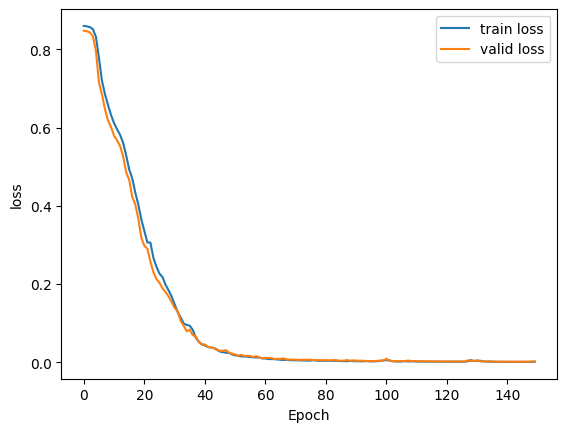

In [129]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [130]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [131]:
pred_train_10hp = lstm_ae_10hp.predict(train_slice_10hp)

12/12 [==============================] - 0s 3ms/step


In [132]:
train_mse_10hp = np.mean(np.square(flatten(train_slice_10hp) - flatten(pred_train_10hp)), axis =1 )
threshold_10hp = np.max(train_mse_10hp)  # np.mean(train_mse_10hp)+ 3*np.std(train_mse_10hp)
print(threshold_10hp)

0.01275591429871414


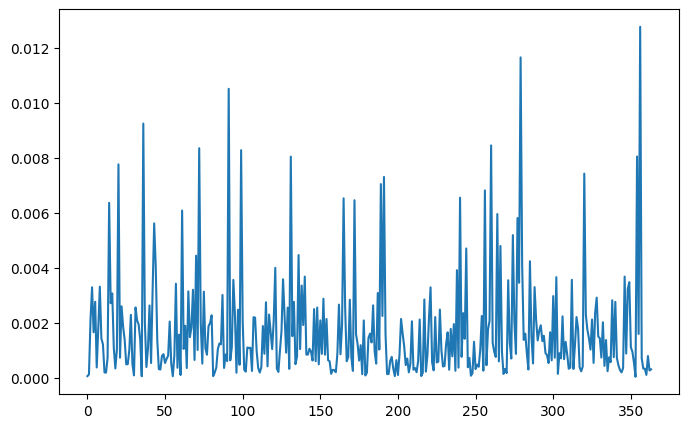

In [133]:
plt.figure(figsize = (8,5))
plt.plot(train_mse_10hp)

In [134]:
test_slice_10hp = slicing(test_scale_10hp,3)

In [135]:
pred_test_10hp = lstm_ae_10hp.predict(test_slice_10hp)

35/35 [==============================] - 0s 2ms/step


In [136]:
test_mse_10hp = np.mean(np.square(flatten(test_slice_10hp) - flatten(pred_test_10hp)), axis =1 )

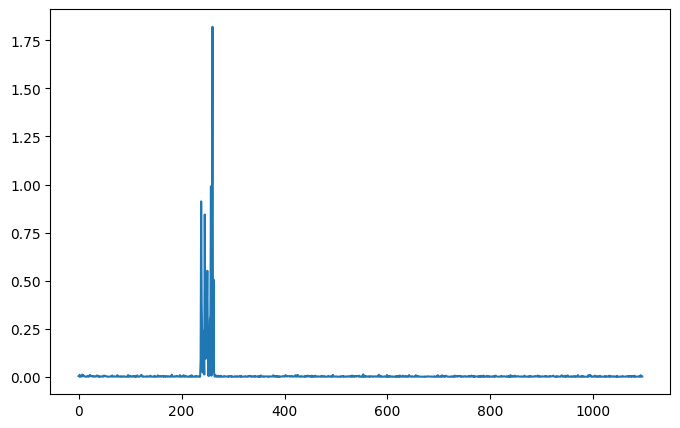

In [137]:
plt.figure(figsize = (8,5))
plt.plot(test_mse_10hp)

In [138]:
anom_10hp = test_mse_10hp > threshold_10hp
np.sum(anom_10hp)

23

In [139]:
def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)

In [140]:
test_data_10hp['y'] = plus(anom_10hp)

In [141]:
test_data_10hp['y']

2403    0
2404    0
2405    0
2406    0
2407    0
       ..
3496    0
3497    0
3498    0
3499    0
3500    0
Name: y, Length: 1098, dtype: int64

# hp50

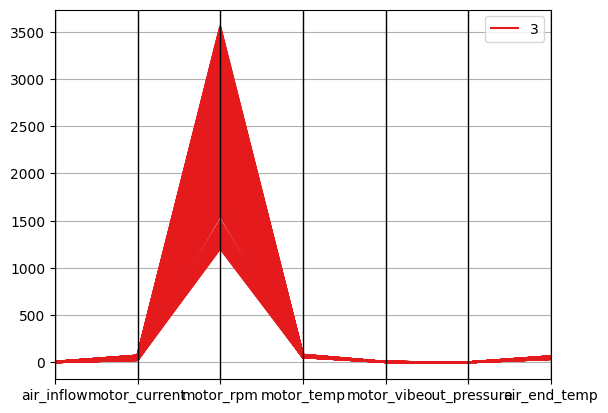

In [ ]:
parallel(train_data, hp50)

In [142]:
scaler_50hp = StandardScaler()

# 설비 라벨 제외
train_scale_50hp = scaler_50hp.fit_transform(train_data_50hp.drop(['type'], axis=1))
test_scale_50hp = scaler_50hp.transform(test_data_50hp.drop(['type'], axis=1))

In [144]:
# lstm 구조에 맞게 데이터 변형

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [145]:
train_slice_50hp = slicing(train_scale_50hp,3)
X_train, X_test = train_test_split(train_slice_50hp, test_size=0.2, random_state=123)

In [146]:
lstm_ae_50hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_50hp.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 3, 7)]            0         
                                                                 
 lstm_86 (LSTM)              (None, 3, 32)             5120      
                                                                 
 lstm_87 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_23 (RepeatVec  (None, 3, 16)            0         
 tor)                                                            
                                                                 
 lstm_88 (LSTM)              (None, 3, 16)             2112      
                                                                 
 lstm_89 (LSTM)              (None, 3, 32)             6272      
                                                          

In [147]:
lstm_ae_50hp.compile(optimizer = 'adam', loss = 'mse')

In [148]:
history = lstm_ae_50hp.fit(X_train, X_train,
                     epochs=150, batch_size=32,
                     validation_data=(X_test, X_test))

Epoch 1/150
8/8 [==============================] - 6s 89ms/step - loss: 0.8490 - val_loss: 0.8961
Epoch 2/150
8/8 [==============================] - 0s 12ms/step - loss: 0.8479 - val_loss: 0.8952
Epoch 3/150
8/8 [==============================] - 0s 11ms/step - loss: 0.8462 - val_loss: 0.8931
Epoch 4/150
8/8 [==============================] - 0s 12ms/step - loss: 0.8429 - val_loss: 0.8877
Epoch 5/150
8/8 [==============================] - 0s 11ms/step - loss: 0.8339 - val_loss: 0.8740
Epoch 6/150
8/8 [==============================] - 0s 12ms/step - loss: 0.8101 - val_loss: 0.8410
Epoch 7/150
8/8 [==============================] - 0s 12ms/step - loss: 0.7635 - val_loss: 0.8230
Epoch 8/150
8/8 [==============================] - 0s 12ms/step - loss: 0.7225 - val_loss: 0.7545
Epoch 9/150
8/8 [==============================] - 0s 12ms/step - loss: 0.6643 - val_loss: 0.7156
Epoch 10/150
8/8 [==============================] - 0s 11ms/step - loss: 0.6240 - val_loss: 0.7124
Epoch 11/150
8/8 [=

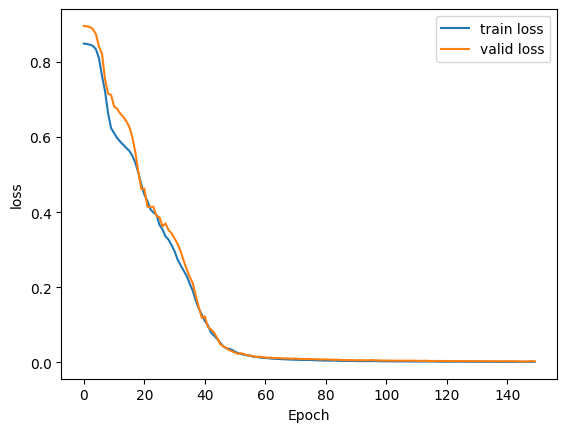

In [149]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [150]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [151]:
pred_train_50hp = lstm_ae_50hp.predict(train_slice_50hp)

10/10 [==============================] - 0s 2ms/step


In [152]:
train_mse_50hp = np.mean(np.square(flatten(train_slice_50hp) - flatten(pred_train_50hp)), axis =1 )
threshold_50hp = np.max(train_mse_50hp)
print(threshold_50hp)

0.03728364391498494


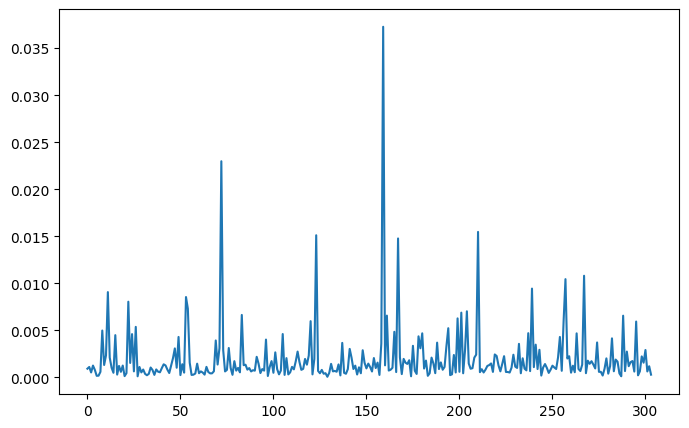

In [153]:
plt.figure(figsize = (8,5))
plt.plot(train_mse_50hp)
# plt.ylim(0, 1)

In [154]:
test_slice_50hp = slicing(test_scale_50hp,3)

In [155]:
pred_test_50hp = lstm_ae_50hp.predict(test_slice_50hp)

29/29 [==============================] - 0s 2ms/step


In [156]:
test_mse_50hp = np.mean(np.square(flatten(test_slice_50hp) - flatten(pred_test_50hp)), axis =1 )

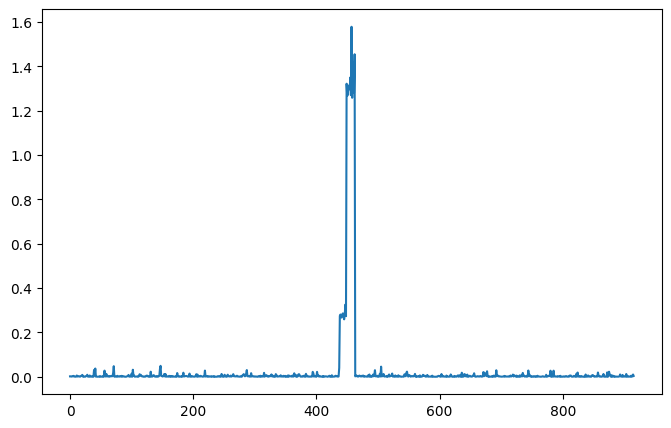

In [157]:
plt.figure(figsize = (8,5))
plt.plot(test_mse_50hp)

In [158]:
anom_50hp = test_mse_50hp > threshold_50hp
np.sum(anom_50hp)

29

In [159]:
test_data_50hp

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
3501,2.40,28.0,1374.0,56.27,3.96,0.7,37.68,3
3502,2.84,33.0,1625.0,59.06,4.10,0.7,40.81,3
3503,5.66,66.0,3236.0,76.96,5.00,0.7,60.95,3
3504,2.92,34.0,1667.0,59.52,4.13,0.7,41.34,3
3505,5.32,62.0,3039.0,74.77,4.89,0.7,58.49,3
...,...,...,...,...,...,...,...,...
4414,4.99,58.0,2852.0,72.69,4.78,0.7,56.15,3
4415,3.16,37.0,1805.0,61.06,4.20,0.7,43.06,3
4416,4.56,53.0,2603.0,69.92,4.65,0.7,53.04,3
4417,6.23,72.0,3560.0,80.56,5.18,0.7,65.00,3


In [160]:
def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)


In [161]:
test_data_50hp['y'] = plus(anom_50hp)

In [162]:
test_data_50hp['y']

3501    0
3502    0
3503    0
3504    0
3505    0
       ..
4414    0
4415    0
4416    0
4417    0
4418    0
Name: y, Length: 918, dtype: int64

# pred 합치기

test_data_30hp

test_data_20hp

test_data_10hp

test_data_50hp

In [231]:
answer = pd.concat([test_data_30hp['y'], test_data_20hp['y'], test_data_10hp['y'], test_data_50hp['y']]).sort_index()
answer = pd.concat([test_data['type'], answer], axis=1)
answer.rename(columns={'y':'label'}, inplace = True)

In [232]:
answer

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
7384,7,0
7385,7,0
7386,7,0
7387,7,0


In [233]:
answer.to_csv("/content/drive/MyDrive/번천/answer_model3.csv")